## Backtesting sma crossover strategy

### Go to project root

In [1]:
import os
from pathlib import Path

#list the current work dir
cwd = os.getcwd()
current_path = Path(cwd)
project_root = current_path.parent.parent.parent

#change the current work dir
os.chdir(project_root)

In [2]:
from collections import deque

from trazy_analysis.bot.event_loop import EventLoop
from trazy_analysis.broker.broker_manager import BrokerManager
from trazy_analysis.broker.simulated_broker import SimulatedBroker
from trazy_analysis.broker.binance_fee_model import BinanceFeeModel
from trazy_analysis.common.clock import SimulatedClock
from trazy_analysis.feed.feed import CsvFeed, Feed
from trazy_analysis.indicators.indicators_manager import IndicatorsManager
from trazy_analysis.models.asset import Asset
from trazy_analysis.order_manager.order_creator import OrderCreator
from trazy_analysis.order_manager.order_manager import OrderManager
from trazy_analysis.order_manager.position_sizer import PositionSizer
from trazy_analysis.strategy.strategies.sma_crossover_strategy import (
    SmaCrossoverStrategy,
)
from datetime import datetime, timedelta
import pytz
from trazy_analysis.db_storage.influxdb_storage import InfluxDbStorage
from trazy_analysis.common.ccxt_connector import CcxtConnector
from trazy_analysis.market_data.historical.ccxt_historical_data_handler import CcxtHistoricalDataHandler

from trazy_analysis.feed.feed import ExternalStorageFeed
from trazy_analysis.statistics.pyfolio_statistics import PyfolioStatistics
from trazy_analysis.statistics.statistics import Statistics
from trazy_analysis.statistics.quantstats_statistics import QuantstatsStatistics

import pyfolio as pf

/Users/moussadiakite/Google_Drive/Projects/MInvest/Trazy/trazy_analysis/env/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [3]:
asset = Asset(symbol="BTCUSDT", exchange="BINANCE")

In [4]:
LOOKBACK_PERIOD = timedelta(days=1)
end = datetime.now(pytz.UTC)
start = end - LOOKBACK_PERIOD

In [5]:
start

datetime.datetime(2021, 8, 27, 19, 53, 12, 528304, tzinfo=<UTC>)

In [6]:
end

datetime.datetime(2021, 8, 28, 19, 53, 12, 528304, tzinfo=<UTC>)

In [7]:
db_storage = InfluxDbStorage()

In [8]:
exchanges_api_keys = {
    "BINANCE": {
        "key": None,
        "secret": None,
        "password": None,
    }
}

ccxt_connector = CcxtConnector(exchanges_api_keys=exchanges_api_keys)
historical_data_handler = CcxtHistoricalDataHandler(ccxt_connector)
historical_data_handler.save_ticker_data_in_db_storage(
    asset, db_storage, start, end
)

In [9]:
assets = [asset]
events = deque()

feed: Feed = ExternalStorageFeed(
    assets = assets,
    events = events,
    time_unit = timedelta(minutes=1),
    start = start,
    end = end,
    db_storage = db_storage,
    file_storage = None,
    market_cal = None,
)

strategies = {SmaCrossoverStrategy: [SmaCrossoverStrategy.DEFAULT_PARAMETERS]}
clock = SimulatedClock()
broker = SimulatedBroker(clock, events, initial_funds=10000.0, fee_model=BinanceFeeModel())
broker.subscribe_funds_to_portfolio(10000.0)
broker_manager = BrokerManager(brokers={"BINANCE": broker}, clock=clock)
position_sizer = PositionSizer(broker_manager=broker_manager, integer_size=False)
order_creator = OrderCreator(broker_manager=broker_manager)
order_manager = OrderManager(
    events=events,
    broker_manager=broker_manager,
    position_sizer=position_sizer,
    order_creator=order_creator,
)
indicators_manager = IndicatorsManager(preload=True, initial_data=feed.candles)
event_loop = EventLoop(
    events=events,
    assets=assets,
    feed=feed,
    order_manager=order_manager,
    strategies_parameters=strategies,
    indicators_manager=indicators_manager,
)
event_loop.loop()

print(broker.get_portfolio_cash_balance())

9942.784018382625


In [ ]:
event_loop.equity_dfs["SmaCrossoverStrategy"]["BINANCE"]

In [ ]:
event_loop.positions_dfs["BINANCE"]

In [ ]:
event_loop.transactions_dfs["BINANCE"]

In [ ]:
import pandas as pd

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(event_loop.equity_dfs['SmaCrossoverStrategy']['BINANCE'][event_loop.equity_dfs['SmaCrossoverStrategy']['BINANCE']['returns'] != 0])

In [10]:
equity = event_loop.equity_dfs['SmaCrossoverStrategy']['BINANCE']
positions = event_loop.positions_dfs["BINANCE"]
transactions = event_loop.transactions_dfs["BINANCE"]

In [ ]:
pf.timeseries.perf_stats(returns=returns, positions=positions, transactions=transactions).to_frame(name="Backtest results")

In [ ]:
pf.create_round_trip_tear_sheet(returns=returns, positions=positions, transactions=transactions)

In [ ]:
returns

In [ ]:
tearsheet = PyfolioStatistics(
    equity=equity,
    positions=positions,
    transactions=transactions,
    title='Sma Crossover'
)
tearsheet.get_tearsheet()

In [ ]:
tearsheet = Statistics(
    equity=equity,
    positions=positions,
    transactions=transactions,
    title='Sma Crossover'
)
tearsheet.plot_tearsheet()

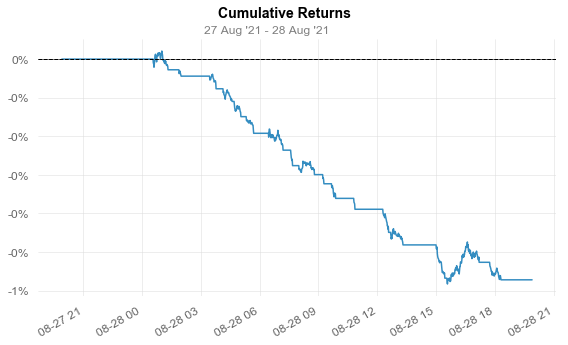

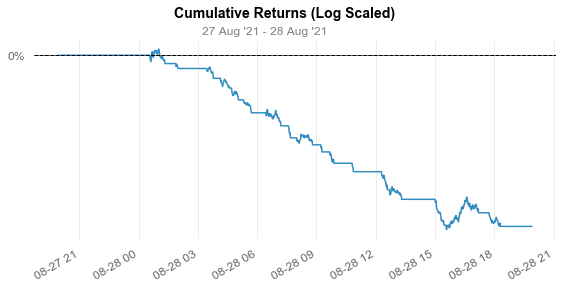

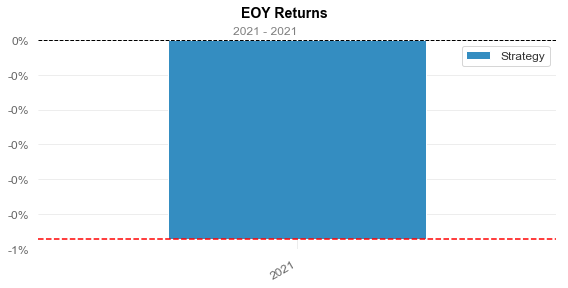

/Users/moussadiakite/Google_Drive/Projects/MInvest/Trazy/trazy_analysis/env/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


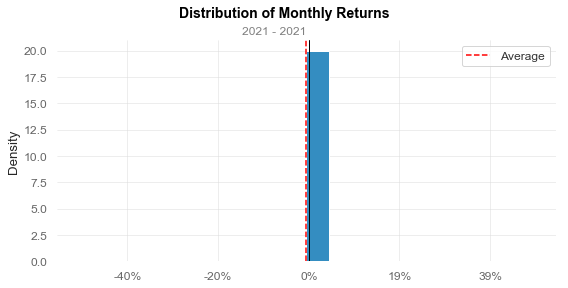

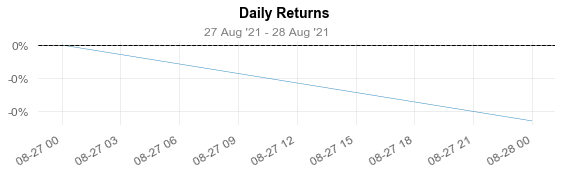

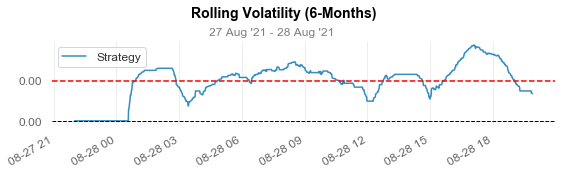

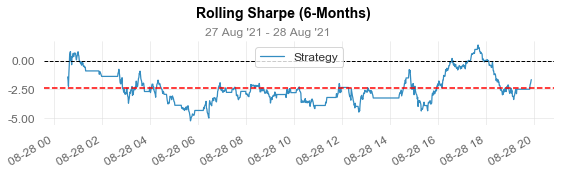

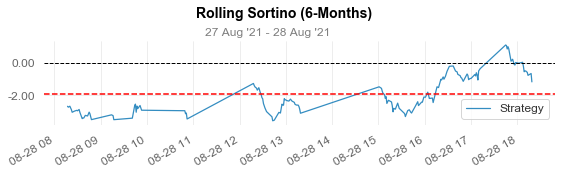

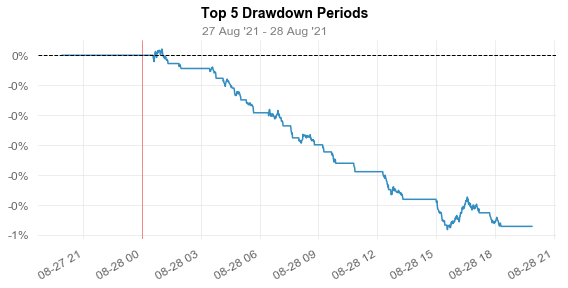

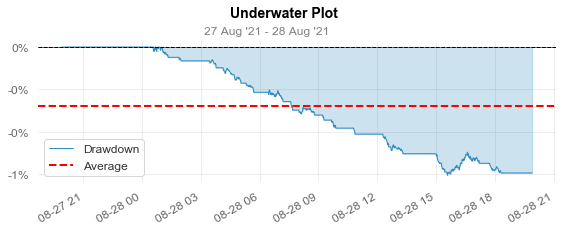

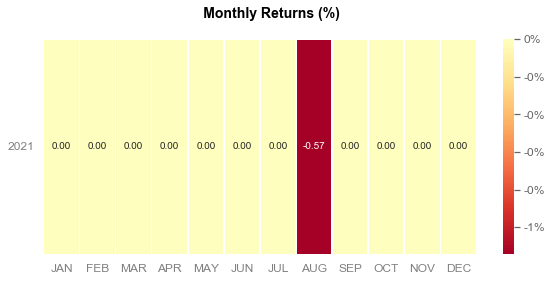

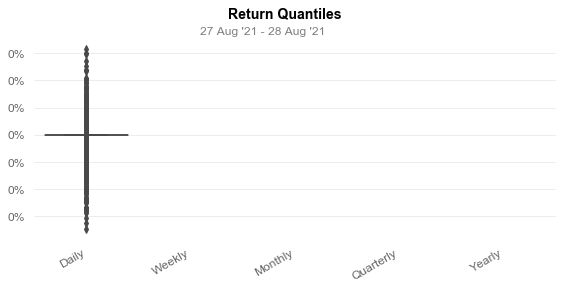

In [11]:
tearsheet = QuantstatsStatistics(
    equity=equity,
    positions=positions,
    transactions=transactions,
    title='Sma Crossover'
)
tearsheet.plot_tearsheet()